In [134]:
######################
minsep = 10.      # Min theta
maxsep = 90.      # Max theta
nbins = 15        # Bins in theta
nmult = 50        # nmult := Nr/Nd
#npatch = 50
nbootstrap = 100  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
nquant = 6        # No. of quantiles to split sample in Mag_K
cutoff = 3        # Ignore 'cutoff' last bins for integration

seed1 = 12936
seed2 = 19284

passivecrop = True
write = True
plot = True
config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": brute, \
            "metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)
# Galaxy Mask
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
mask_eve = np.where([abs(eve.galactic.b)>5.*(u.degree)])[1]
events_a8 = events_a8[mask_eve]

# Read Gxs
if passivecrop==True: filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
gxs = ascii.read(filename_g)

# Bright/Faint
quantiles = np.quantile(gxs['K_abs'],np.linspace(0,1,nquant+1))

data = []

for q in range(nquant):
  data.append(

    gxs[(gxs['K_abs']>quantiles[q])&(gxs['K_abs']<quantiles[q+1])]

  )


In [135]:
def get_xibs(data,nbootstrap,nbins,rcat,ecat,config):
    xi_bs = np.zeros((nbootstrap,nbins))
    varxi_bs = np.zeros((nbootstrap,nbins))

    dd = treecorr.NNCorrelation(config)
    dr = treecorr.NNCorrelation(config)
    rr = treecorr.NNCorrelation(config)
    rd = treecorr.NNCorrelation(config)

    for n in range(nbootstrap):
        databs = np.random.choice(data,size=len(data))
        gcat = treecorr.Catalog(ra=databs['_RAJ2000'], dec=databs['_DEJ2000'],\
                                ra_units='deg', dec_units='deg')

        rr.process(rcat)
        dd.process(gcat,ecat)
        dr.process(gcat,rcat)
        rd.process(ecat,rcat)

        xi_bs[n], varxi_bs[n] = dd.calculateXi(rr=rr,dr=dr,rd=rd)
    return xi_bs, varxi_bs, dd.meanr

import treecorr

# TreeCorr Catalogues
ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], \
                        ra_units='deg', dec_units='deg')

rcat = []
for q in range(nquant):
    rand_ra, rand_dec = generate_RandomCatalogue(data[q]['_RAJ2000'],data[q]['_DEJ2000'],\
                                               nmult, mask=True)
    rcat.append(treecorr.Catalog(ra=rand_ra, dec=rand_dec, \
                        ra_units='deg', dec_units='deg'))

xi_bs = []
varxi_bs = []
for q in range(nquant):
    results =  get_xibs(data[q],nbootstrap,nbins,rcat[q],ecat,config) 
    xi_bs.append(results[0])
    varxi_bs.append(results[1])
    print(q+1,'/',nquant)
th = results[2]


1 / 6
2 / 6
3 / 6
4 / 6
5 / 6
6 / 6


#### Plot

Saving ../data/cross_treecorr_nq6_nmult50_nbs100_passivecrop


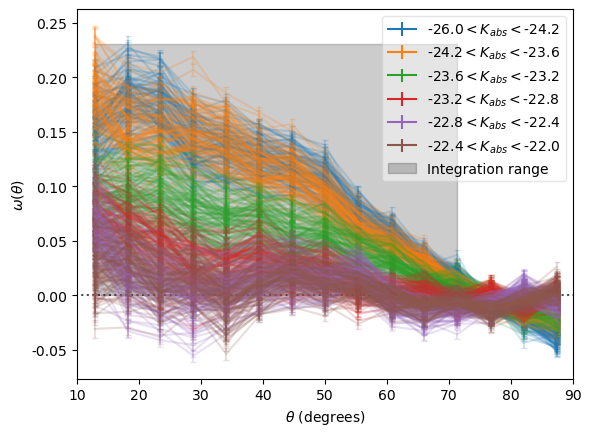

In [136]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)
fillalpha=.2
xi1_max = [np.max(xi_bs[0][:,i]) for i in range(nbins)][:-cutoff]
ax.fill_between(th[:-cutoff], y1=np.max(xi1_max), color='k', alpha=fillalpha)

alpha=.2
capsize = 2
labels = []
for q in range(nquant):
    labels.append(
         f'{quantiles[q]:.1f}'+r'$<K_{abs}<$'+f'{quantiles[q+1]:.1f}'
    )

c = ['C00','C01','C02','C03','C04','C05']
for q in range(nquant):
    for i in range(nbootstrap):
        line = ax.errorbar(th, xi_bs[q][i], yerr=np.sqrt(varxi_bs[q][i]), \
                    color=c[q], label=labels[q],\
                    alpha=alpha, capsize=capsize)

#Legend
handles = [plt.errorbar([],[],yerr=1,color=c[i]) for i in range(nquant)]#,\
handles.append(plt.fill_between([],[],color='k',alpha=fillalpha))
labels_ = [labels[i] for i in range(nquant)]
labels_.append('Integration range')
plt.legend(handles, labels_, loc=1, fancybox=True, framealpha=0.5)


ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if plot==True:
    plotname = f'../data/cross_treecorr_nq{nquant}_nmult{nmult}_nbs{nbootstrap}'
    if passivecrop==True: plotname+='_passivecrop'
    print('Saving',plotname)
    plt.savefig(plotname+'.png')

plt.show()


#### Integration

In [140]:
from scipy import integrate

int = []
for q in range(nquant):
    int.append(np.zeros(nbootstrap))

for q in range(nquant):
    for i in range(nbootstrap):
        int[q][i] = integrate.trapezoid(xi_bs[q][i][:-cutoff],x=th[:-cutoff])

ratio_mean = np.zeros(nquant)
std_mean = np.zeros(nquant)

for q in range(nquant):
    ratio_mean[q] = np.mean(int[q])/np.mean(int[0])
    std_mean[q] = np.std(int[q])/np.mean(int[0])


#### Plot cocientes

[1.         0.5066646  0.32916211 0.22295316 0.15556828 0.10776456] [1.         0.94576033 0.52637702 0.23004267 0.08868676 0.10335269]


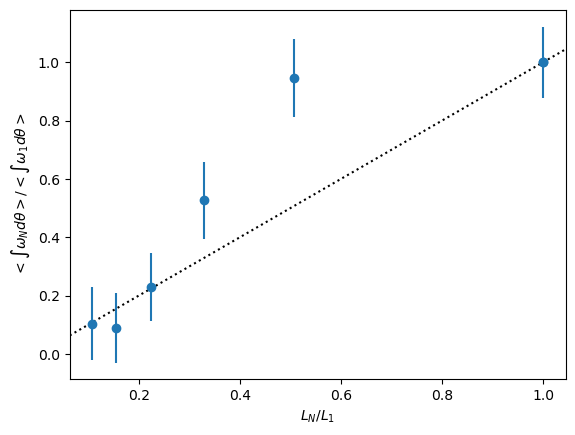

In [141]:
fig, ax = plt.subplots()

meanMag = np.zeros(nquant)
for q in range(nquant):
    meanMag[q] = np.mean(data[q]['K_abs'])


L_ratio = np.zeros(nquant)
for q in range(nquant):
    L_ratio[q] = 10**(-.4*(meanMag[q]-meanMag[0]))

print(L_ratio,ratio_mean)

ax.scatter(1,1,c='C00')
for i in range(len(ratio_mean)):
    ax.errorbar(L_ratio[i],ratio_mean[i],yerr=std_mean[i],c='C00',fmt='o')
#ax.plot([1, 3.53], [1, 4.2])#, transform=ax.transAxes)
ax.axline((1,1),slope=1,c='k',ls=':')
ax.set_ylabel(r'$<\int\omega_Nd\theta>/<\int\omega_1d\theta>$')
ax.set_xlabel(r'$L_N/L_1$')

plotname = f'int_L_nquant{nquant}_nbs{nbootstrap}.png'
#plt.savefig('../plots/'+plotname)

plt.show()

#### Write

In [139]:
filename = f'../data/int_L_nq{nquant}_nbs{nbootstrap}.npz'
names = ['int_ratio','L_ratio','int_std']

print(filename)
ascii.write(np.column_stack([ratio_mean,L_ratio,std_mean]),filename,names=names,overwrite=True)

../data/int_L_nq6_nbs100.npz
